# Анализ результатов A/B теста онлайн-магазина

***Описание проекта***

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

***Описание данных***

Данные для первой части

Файл /datasets/hypothesis.csv.

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл /datasets/orders.csv.

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Часть 1. Приоритизация гипотез.

Загрузка библиотек:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import seaborn as sns

Чтение файлов:

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
pd.set_option('max_colwidth', 150) 

Посмотрим содержание:

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


В таблицах orders hypothesis названия столбцов приведем к общему стилю, в orders и visitors проверим наличие дубликатов:

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [7]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


Посмотрим информацию по датасетам:

In [8]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Изменим тип данных в столбцах с датой на datetime:

In [11]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y.%m.%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y.%m.%d')

Проверим наличие пропусков:

In [12]:
print(orders.isna().sum())
print(visitors.isna().sum())

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64
date        0
group       0
visitors    0
dtype: int64


### ICE

Применим фреймворк ICE для приоритизации гипотез:

In [13]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### RICE

Применим фреймворк RICE для приоритизации гипотез:

In [14]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


***Вывод:***

Наиболее интересные гипотезы по ICE:

- Запустить акцию, дающую скидку на товар в день рождения - 16.20
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - 13.33
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - 11.20
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - 8.00
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - 7.00

По RICE:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - 112.0
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - 56.0
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - 40.0
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию - 8.00
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа - 7.00

По сравнению с ICE RICE имеет так же показатель охвата пользователей, что немаловажно и именно этот показатель имеет влияние на различие между ICE и RICE, а так же на различие в местах списка. 

Даже при условии, что есть различие в числах и местах в топ-5 гипотез вошли одни и те же, поэтому их можно выделить как самые перспективные.

## Часть 2. Анализ A/B-теста

### График кумулятивной выручки по группам

Создаем датафрейм с кумулятивными данными для построения графика:

In [15]:
date_group = orders[['date','group']].drop_duplicates()

orders_agg = (date_group
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                    orders['group'] == x['group'])]
                    .agg({'date':'max', 
                          'group':'max', 
                          'transaction_id':'nunique', 
                          'visitor_id':'nunique', 
                          'revenue':'sum'}), axis=1)
                    .sort_values(by=['date','group']))

visitors_agg = (date_group
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                               visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 
                            'group' : 'max', 
                            'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

cumulative= orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Создаем датафрейми с данными по группам:

In [16]:
cumulative_revenue_a = cumulative[cumulative['group']=='A'][['date','revenue', 'orders']]

cumulative_revenue_b = cumulative[cumulative['group']=='B'][['date','revenue', 'orders']]

Строим график:

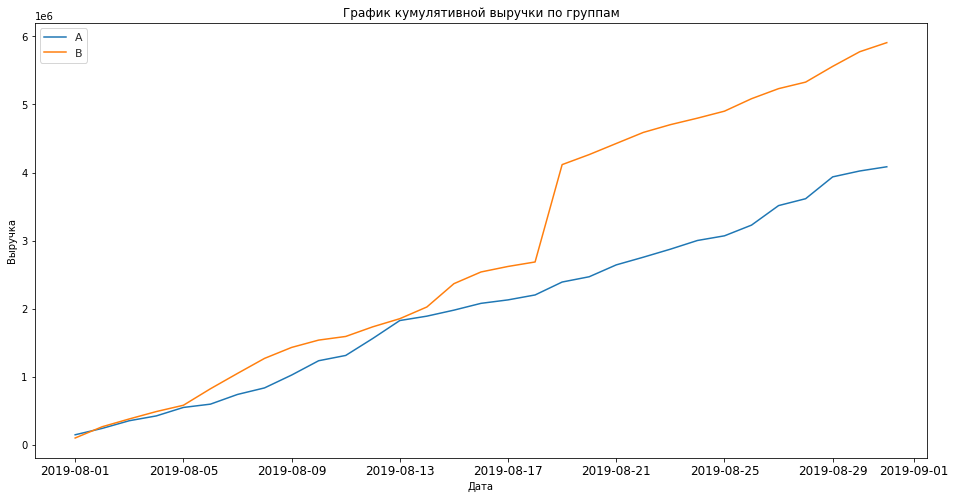

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

sns.set(style='whitegrid')
plt.tick_params(axis='x', which='major', labelsize=12)
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

По графику видим, что за все время проведения теста группа B показывала результаты лучше, но была достаточно близко у уровню группы A. После 17го числа группа B достаточно резко возрасла в показателях, чем резко увеличила разрывв между граппами.

### График кумулятивного среднего чека по группам

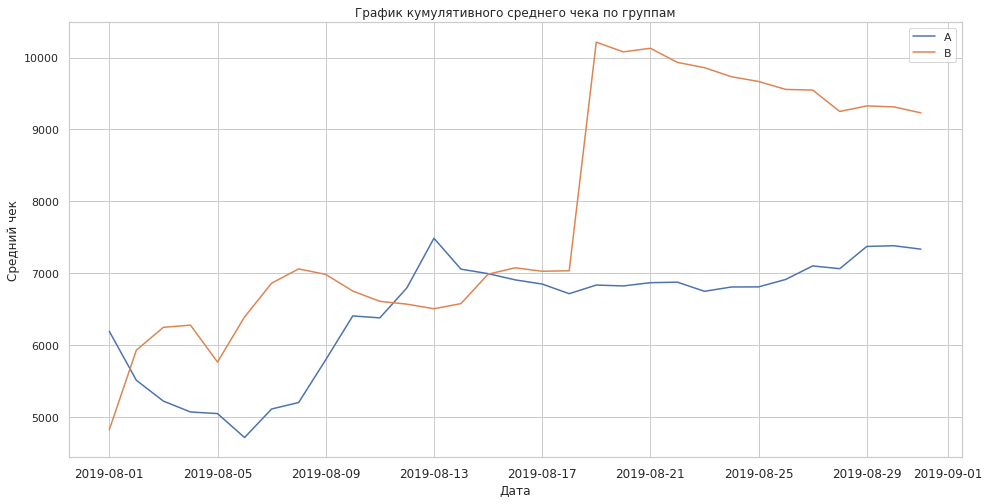

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.tick_params(axis='x', which='major', labelsize=12)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend();

Здесь график уже не такой плавный, но все равно группа B показывает значения лучше и так же с резким скачком после 17го числа.

### График относительного изменения кумулятивного среднего чека группы B к группе A

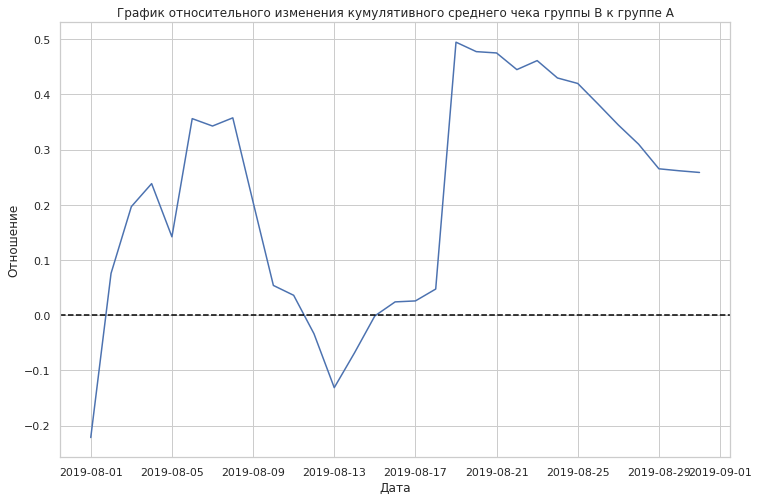

In [19]:
merged_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, 
                                            left_on='date', 
                                            right_on='date', 
                                            how='left', 
                                            suffixes=['A', 'B'])

plt.figure(figsize=(12, 8))
plt.plot(merged_revenue['date'], 
         (merged_revenue['revenueB']/merged_revenue['ordersB'])/
         (merged_revenue['revenueA']/merged_revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Отношение')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');

Заметим резкие изменения, на что вероятно влияют аномальные значения.

### График кумулятивного среднего количества заказов на посетителя по группам

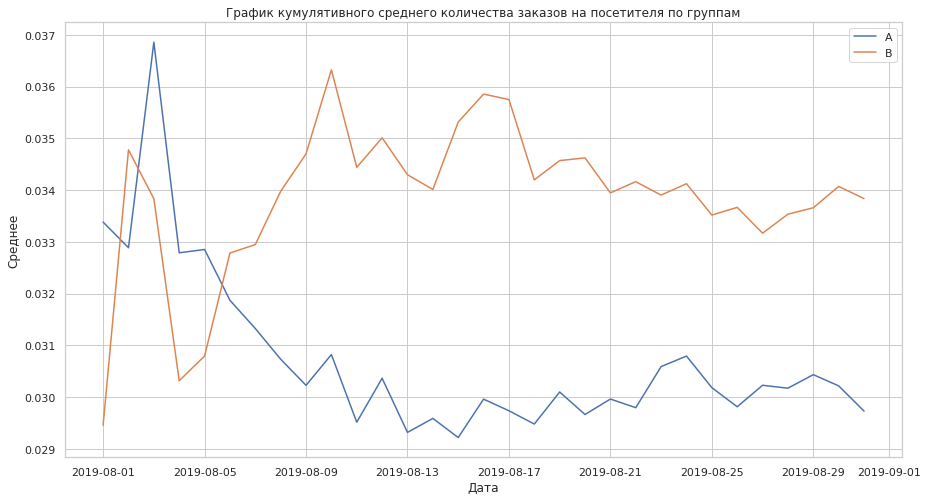

In [20]:
cumulative['conversion'] = cumulative['orders']/cumulative['visitors']

cumulative_a = cumulative[cumulative['group']=='A']
cumulative_b = cumulative[cumulative['group']=='B']

plt.figure(figsize=(15, 8))
plt.plot(cumulative_a['date'], cumulative_a['conversion'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам');

Со старта теста показатели группы A были лучше, но после резких скачков группа B опередила после 6го числа. В районе 17го числа закончилась раскачка и показатели стабилизировались.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

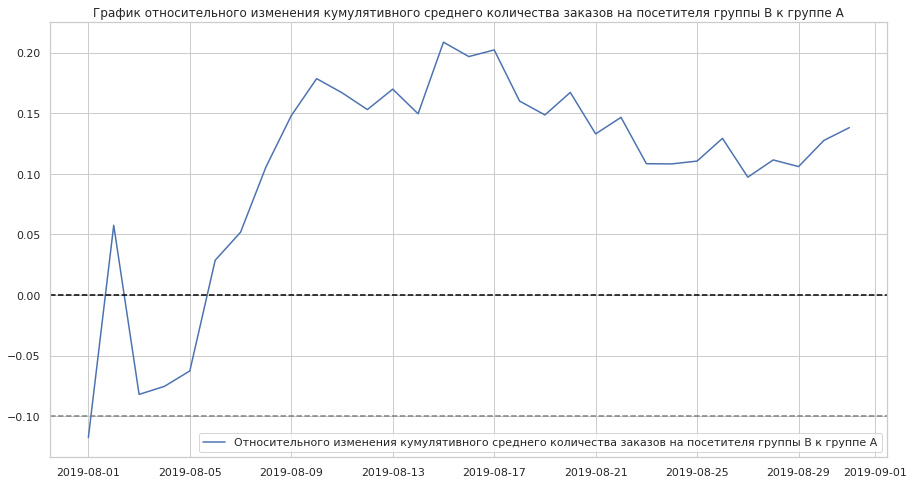

In [21]:
merged_count = cumulative_a[['date','conversion']].merge(cumulative_b[['date','conversion']], 
                                                         left_on='date', 
                                                         right_on='date', 
                                                         how='left', 
                                                         suffixes=['A', 'B'])
plt.figure(figsize=(15, 8))
plt.plot(merged_count['date'], 
         merged_count['conversionB']/merged_count['conversionA']-1, 
         label="Относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")

plt.legend()
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');

### Точечный график количества заказов по пользователям

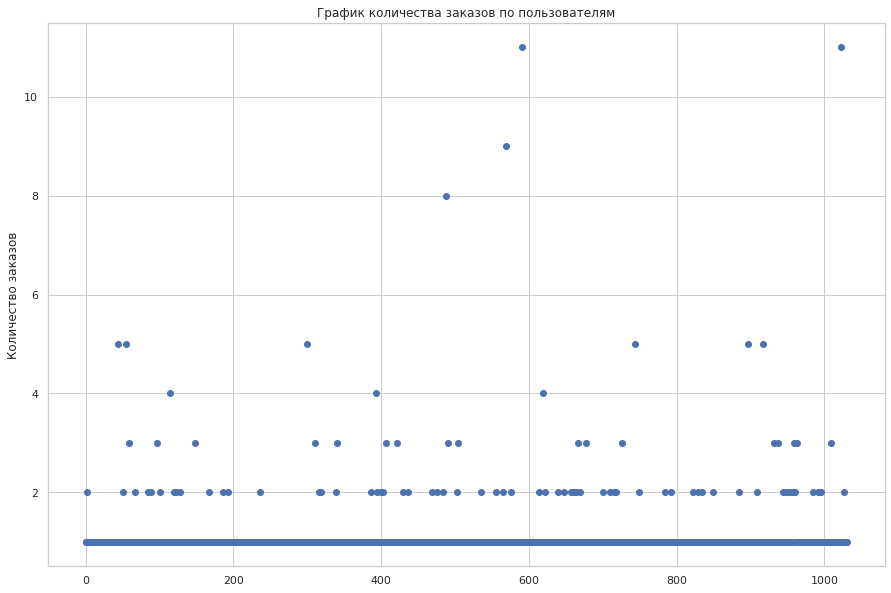

In [22]:
orders_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_users.columns = ['userId', 'orders']

x_values = pd.Series(range(0,len(orders_users)))
plt.figure(figsize=(15, 10))
plt.scatter(x_values, orders_users['orders'])
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям');

Большя часть польователей совершают по одному заказу, мало кто выбился выше 2, но и есть выбросы в виде совершивших более 10 заказов

### 95-й и 99-й перцентили количества заказов на пользователя

In [23]:
np.percentile(orders_users['orders'], [95, 99])

array([2., 4.])

Более 2 заказов совершало только 5% пользователей, а более 4 лишь 1%
Границей для пределения аномальных пользователей я бы назвал тех, кто совершил более 4 заказов, так как это максимально явный выброс и это минимально повлияет на репрезентативность данных. 

### Точечный график стоимостей заказов

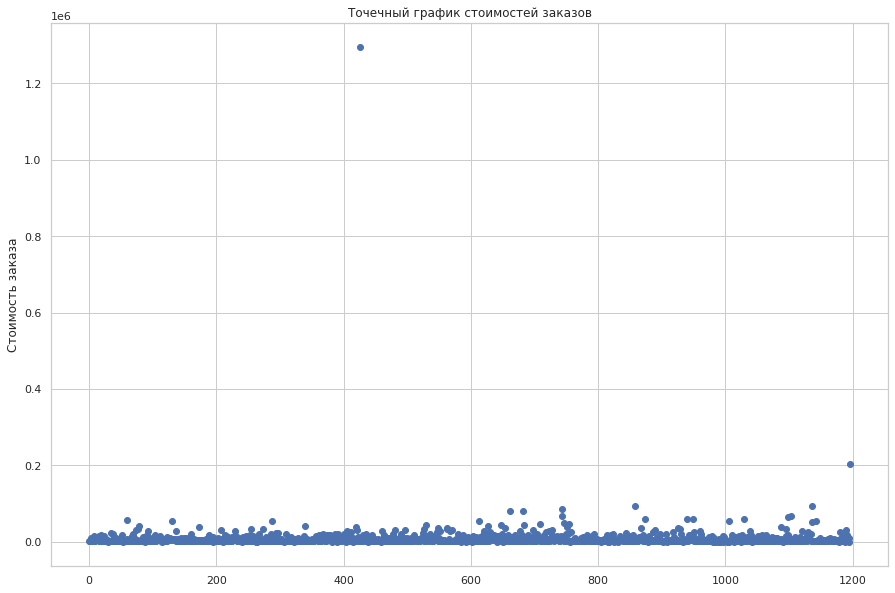

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 10))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа');

Есть явный выброс на стоимости более 1.2 млн, а так же 200 тыс. Возможно самый крупный заказ и помог группе B выбиться в лидеры.

### 95-й и 99-й перцентили стоимости заказов

In [25]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Более 28 тыс. заплатили только 5% пользователей, а 1% потратил более 58 тыс. на заказы. Здесь так же порогом обозначим 1%, то есть более 58 тыс.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:

- H₀: Среднее количество заказов на пользователя между группами не отличается.
- H₁: Среднее количество заказов на пользователя между группами не отличается.

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateA'].sum() - 
                                                                        len(ordersByUsersA['orders'])), 
                                                        name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateB'].sum() - 
                                                                        len(ordersByUsersB['orders'])), 
                                                        name='orders')],axis=0)


In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders'] 

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateA'].sum() - 
                                                                        len(ordersByUsersA['orders'])), 
                                                        name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateB'].sum() - 
                                                                        len(ordersByUsersB['orders'])), 
                                                        name='orders')],axis=0)

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


In [28]:
alpha = .05 
results = stats.mannwhitneyu(sampleA, sampleB)

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print('отношение группы B к группе A:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))      

p-значение:  0.017
Отвергаем нулевую гипотезу
отношение группы B к группе A: 0.138


По сырым данным статистическая разница между средним количеством заказов есть, видимо из-за выбросов.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:

- H₀: Средний чек между группами не отличается.
- H₁: Средний чек между группами отличается.

In [29]:
alpha = .05 
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   
    
print('отношение группы B к группе A:',"{0:.3f}".format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue']
                       .mean()-1))     

p-значение:  0.729
Не получилось отвергнуть нулевую гипотезу
отношение группы B к группе A: 0.259


Здесь же статистической разницы нет, что странно, ведь показатели у группы B выше.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Сформулируем гипотезы:

- H₀: Среднее количество заказов на пользователя между группами не отличается.
- H₁: Среднее количество заказов на пользователя между группами не отличается.

In [30]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['user_id'],
    ],
    axis=0,
)

# срезы пользователей
usersWithExpensiveOrders = orders[orders['revenue'] > 58233.2]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [31]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)




alpha = .05 
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)


print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('отношение группы B к группе A:', "{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))    

p-значение:  0.014
Отвергаем нулевую гипотезу
отношение группы B к группе A: 0.153


После отчистки данных результат не изменился, все таки группа B оказалась лучше.

### Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

H₀: Средний чек между группами не отличается.
H₁: Средний чек между группами отличается.

In [32]:
alpha = .05 
results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )

print('p-значение: ', "{0:.3f}".format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print('отношение группы B к группе A:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-значение:  0.851
Не получилось отвергнуть нулевую гипотезу
отношение группы B к группе A: -0.006


Статистически значимой разницы нет, но после отчистки группа A стала превосходить группу B, хоть и ненамного.

## Вывод

По итогам исследования выяснили следующие факты:

- Статистически значимой разницы между группами по среднему чеку нет.
- Статистически зачимая разница между группами по среднему количеству заказов на пользователя есть и победителем становится группа B.

До отчистки данных показатели группы B  оказались лучше на 13.8%, а после отчистки на 15.3%

Данные по одному из показателей оказались выше, поэтому следует остановить тест и зафиксировать победу за группой B